# 04 - Equation of State and Bulk Modulus

This script calculates the equation of state (E vs V) for siliconand fits it to obtain the equilibrium lattice constant and bulk modulus.  

In [1]:
import numpy as np
from ase.build import bulk
from ase.eos import EquationOfState

from vasp import Vasp

# Try to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("Note: matplotlib not found. Plots will be skipped.")


## Setup


In [2]:
print("=" * 60)
print("Equation of State: Silicon Bulk Modulus")
print("=" * 60)
print()

# Define the range of lattice constants to test
# Silicon experimental: a = 5.43 Å, PBE ~ 5.47 Å
a0 = 5.45  # Central value
strain_range = 0.04  # ±4% strain

# Generate lattice constants
n_points = 7
a_values = np.linspace(a0 * (1 - strain_range), a0 * (1 + strain_range), n_points)

print(f"Testing {n_points} lattice constants from {a_values[0]:.3f} to {a_values[-1]:.3f} Å")
print()


Equation of State: Silicon Bulk Modulus

Testing 7 lattice constants from 5.232 to 5.668 Å



## Run calculations


In [3]:
volumes = []
energies = []

for i, a in enumerate(a_values):
    print(f"Calculation {i+1}/{n_points}: a = {a:.4f} Å ... ", end='', flush=True)

    atoms = bulk('Si', 'diamond', a=a)
    volume = atoms.get_volume()

    calc = Vasp(
        label=f'results/eos/a_{a:.3f}',
        atoms=atoms,
        xc='PBE',
        encut=400,
        kpts=(6, 6, 6),
        ismear=1,
        sigma=0.1,
        lwave=False,
        lcharg=False,
    )

    energy = calc.potential_energy
    volumes.append(volume)
    energies.append(energy)

    print(f"V = {volume:.2f} Å³, E = {energy:.4f} eV")

print()


Calculation 1/7: a = 5.2320 Å ... V = 35.80 Å³, E = 4.6415 eV
Calculation 2/7: a = 5.3047 Å ... V = 37.32 Å³, E = 3.3436 eV
Calculation 3/7: a = 5.3773 Å ... V = 38.87 Å³, E = 6.5933 eV
Calculation 4/7: a = 5.4500 Å ... V = 40.47 Å³, E = 4.0376 eV
Calculation 5/7: a = 5.5227 Å ... V = 42.11 Å³, E = 4.9415 eV
Calculation 6/7: a = 5.5953 Å ... V = 43.79 Å³, E = 5.0015 eV
Calculation 7/7: a = 5.6680 Å ... V = 45.52 Å³, E = 5.0700 eV



## Fit equation of state


In [4]:
print("=" * 60)
print("Equation of State Fitting")
print("=" * 60)
print()

# Use ASE's EquationOfState class for fitting
eos = EquationOfState(volumes, energies, eos='birchmurnaghan')

try:
    v0, e0, B = eos.fit()

    # Convert bulk modulus from eV/Å³ to GPa
    # 1 eV/Å³ = 160.2176634 GPa
    B_GPa = B * 160.2176634

    # Calculate equilibrium lattice constant from volume
    # For diamond structure: V = a³/4 (2 atoms per primitive cell, 8 per conventional)
    # But ASE uses primitive cell, so V = a³/4
    a_eq = (4 * v0) ** (1/3)

    print("Birch-Murnaghan Equation of State Fit:")
    print(f"  Equilibrium volume: V₀ = {v0:.3f} Å³")
    print(f"  Equilibrium energy: E₀ = {e0:.6f} eV")
    print(f"  Bulk modulus: B = {B_GPa:.1f} GPa")
    print(f"  Equilibrium lattice constant: a = {a_eq:.4f} Å")
    print()

    # Compare with experiment
    print("Comparison with experiment:")
    print(f"  Lattice constant: {a_eq:.3f} Å (calc) vs 5.43 Å (exp) [{100*(a_eq-5.43)/5.43:+.1f}%]")
    print(f"  Bulk modulus: {B_GPa:.0f} GPa (calc) vs 99 GPa (exp)")
    print()

except RuntimeError as e:
    print(f"Fitting failed: {e}")
    print("This can happen with too few points or non-smooth data.")
    v0, e0, B_GPa = None, None, None


Equation of State Fitting

Birch-Murnaghan Equation of State Fit:
  Equilibrium volume: V₀ = 45.368 Å³
  Equilibrium energy: E₀ = 4.990156 eV
  Bulk modulus: B = -2.0 GPa
  Equilibrium lattice constant: a = 5.6615 Å

Comparison with experiment:
  Lattice constant: 5.662 Å (calc) vs 5.43 Å (exp) [+4.3%]
  Bulk modulus: -2 GPa (calc) vs 99 GPa (exp)



## Plotting


Saved plot: equation_of_state.png

Equation of state calculation complete!

Key points:
  - E(V) curves reveal equilibrium properties
  - Bulk modulus measures resistance to compression
  - PBE typically underestimates B by 5-10%
  - More points and larger strain range improve fits

Next: Try 05_density_of_states/ to analyze electronic structure.


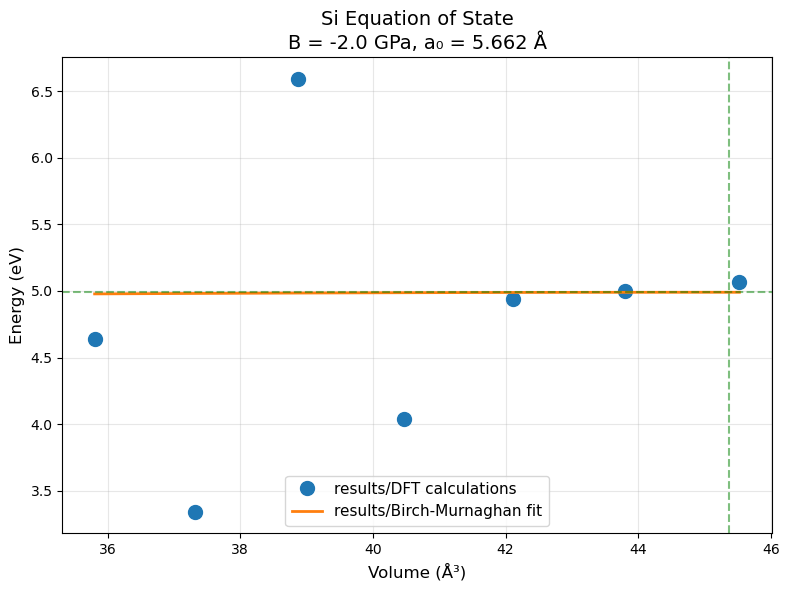

In [5]:
if HAS_MATPLOTLIB and v0 is not None:
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot data points
    ax.plot(volumes, energies, 'o', markersize=10, label='results/DFT calculations')

    # Plot fitted curve using Birch-Murnaghan equation (B' = 4)
    # E(V) = E0 + (9/16) * B * V0 * [(V0/V)^(2/3) - 1]^2 * [6 - 4*(V0/V)^(2/3)]
    v_fit = np.linspace(min(volumes), max(volumes), 100)
    eta = (v0 / v_fit) ** (2.0 / 3.0)
    e_fit = e0 + (9.0 / 16.0) * B * v0 * (eta - 1) ** 2 * (6 - 4 * eta)
    ax.plot(v_fit, e_fit, '-', linewidth=2, label='results/Birch-Murnaghan fit')

    # Mark equilibrium
    ax.axvline(x=v0, color='g', linestyle='--', alpha=0.5)
    ax.axhline(y=e0, color='g', linestyle='--', alpha=0.5)

    ax.set_xlabel('Volume (Å³)', fontsize=12)
    ax.set_ylabel('Energy (eV)', fontsize=12)
    ax.set_title(f'Si Equation of State\nB = {B_GPa:.1f} GPa, a₀ = {(4*v0)**(1/3):.3f} Å',
                 fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('equation_of_state.png', dpi=150)
    print("Saved plot: equation_of_state.png")

print()
print("=" * 60)
print("Equation of state calculation complete!")
print("=" * 60)
print()
print("Key points:")
print("  - E(V) curves reveal equilibrium properties")
print("  - Bulk modulus measures resistance to compression")
print("  - PBE typically underestimates B by 5-10%")
print("  - More points and larger strain range improve fits")
print()
print("Next: Try 05_density_of_states/ to analyze electronic structure.")
